In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d

import pandas as pd
import math
import copy
import pickle
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import BatchNormalization, Layer, TimeDistributed, Dropout
from keras.layers import Dense, Input, Masking, LSTM
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


## Data Loading and Pre-Processing

Let's start by trying to load in our toy jets, and then separate into features (to train on) and labels (to predict).

For features, first try d0, z0, phi, theta, qOverP, (refPx, refPy, refPz)?. Essentially the track parameters.

For labels, Xs, Ys, Zs, Xt, Yt, Zt. That is the secondary and tertiary vertices. Omit the primary as this has been fixed to (0,0,0). This will require some smart selection for c and light jets, where not all vertices are present. If a vertex is not present, could try predicting (0,0,0) or (-1,-1,-1) or previous vertex (prim or sec).

In [2]:
bjets_DF = pd.read_pickle("./bjets_MIN_IPerrs_separate.pkl")
#cjets_DF = pd.read_pickle("./cjets.pkl")
#ljets_DF = pd.read_pickle("./ljets.pkl")

In [3]:
np.linalg.norm(np.array([bjets_DF['tracks'][0]])[:,:,5:8], axis=2) #gives a feel for ordering, lists r of ref postion

array([[0.00000000e+00, 1.51338350e-03, 1.51349181e-03, 6.39290444e-03,
        6.39299002e-03, 2.68756665e-05, 2.20370461e-05, 6.28882218e-06,
        2.45950043e-05,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan]])

Extract the track parameters as our features

In [3]:
%%time
trks=np.zeros((len(bjets_DF), 30, 5))

for i in range(len(bjets_DF)):
    trks[i] = np.array([bjets_DF['tracks'][i]])[:,:,0:5]
    


Wall time: 27.9 s


In [4]:
X = trks # following convention name the features as the vector 'X'

### Track Ordering

Use numpy sort function should work, order in descending value say of impact parameter or something (shouldnt be any negatives)

Maybe want to move this section and order later, after normalization

In [5]:
%%time
Xordered = copy.copy(X)#
Xordered = np.nan_to_num(Xordered)

for i,jet in enumerate(Xordered[:,1:]):
    Xordered[i,1:] = jet[np.abs(jet[:,0]).argsort()[::-1]]


Wall time: 5.09 s


In [6]:
Xordered[5]

array([[ 0.00000000e+00,  0.00000000e+00,  7.85401221e-01,
         7.85385606e-01,  2.03575370e-05],
       [ 2.53864068e-03, -9.35718254e-04,  1.01956011e+00,
         6.46098546e-01,  2.18954695e-04],
       [ 1.03940795e-03,  5.88169106e-04,  7.82932879e-01,
         7.76422993e-01,  2.36268539e-04],
       [ 2.81902833e-04,  2.24104502e-04,  8.36959886e-01,
         7.51062329e-01,  8.46175955e-05],
       [ 2.34737378e-04,  1.67468072e-05,  8.30335571e-01,
         7.35367562e-01,  8.43133487e-05],
       [ 5.05658114e-05,  4.15250929e-05,  6.83020540e-01,
         8.86462535e-01,  5.64068021e-05],
       [ 2.00091696e-06,  2.77014161e-07,  7.18407642e-01,
         7.33982804e-01,  1.11788994e-04],
       [-1.33094960e-06,  4.16166694e-07,  8.14479189e-01,
         8.36968238e-01,  5.62930653e-04],
       [ 6.29181397e-07,  1.17581884e-06,  1.20298441e+00,
         1.33208692e+00,  9.82380302e-04],
       [-2.03025840e-08,  1.08385208e-07,  7.06717601e-01,
         6.70453788e-01

## Data Normalization

I think we want to ensure all paramters are approx unity in order not to bias the RNN towards a particular feature. phi and theta are already approx unity (order pi), but qOverP is very small order 1e-4 and IP are also small (but scale multiple orders of magnitude) 1e-6 to 1e-2 (unfortunately)

So want to use a min max scaler or RobustScaler (so we don't bias to outliers).

C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.509101e+06, 4.850100e+04, 4.808600e+04, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00]),
 array([-4.48167053e-06,  1.05739131e-05,  2.56294966e-05, ...,
         2.60567335e-02,  2.60717891e-02,  2.60868447e-02]),
 <a list of 1733 Patch objects>)

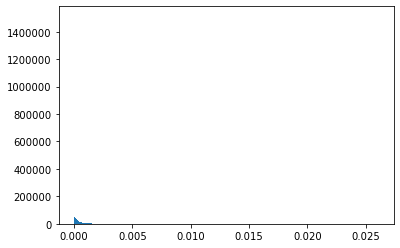

In [7]:
d0s = np.reshape(X[:,:,0],(30*len(bjets_DF)))
d0s = d0s[~(d0s == np.NaN)]
d0s
plt.hist(d0s,bins='scott') # I believe this is the array containing all the d0s

In [8]:
print(np.mean(X[:,:,0]*1e4))
print(np.mean(X[:,:,1]*1e6)) # difficult one to handle this due to large variance
print(np.mean(X[:,:,4]*1e4))
print()
print(np.std(X[:,:,0]*1e4)) # these are troublesome yes
print(np.std(X[:,:,1]*1e6))
print(np.std(X[:,:,4]*1e4))
# so we will apply the above multiples, this will bring the averages to about unity (unfortunately some outliers will
# be very large, so probs better to use a min max scaler or something but then exclude 0?)

nan
nan
nan

nan
nan
nan


Here we scale all the features to bring them to average unity, this is very simplistic so we need a better way in future

It means it works faster.

Here we instead use a min-max scaler to try and solve the problem of scale i.e. certain IPs are 10^4 times larger than others. The min-max scaler means all features will be scaled equivalently.

Here we go, minmax scaling

In [8]:
Xscaled = copy.copy(X)

In [9]:
%%time
for track_variable in range(5):
    var_to_scale = Xscaled[:,:,track_variable]
    if (track_variable == 0):
        print((track_variable == 0))
        print(track_variable)
        scaler=RobustScaler()
    elif (track_variable == 4):
        print((track_variable == 4))
        print(track_variable)
        scaler=RobustScaler()
    elif (track_variable == 1):
        print(track_variable)
        scaler = RobustScaler()
    else:
        scaler=MinMaxScaler([-1,1])
    scaler.fit(var_to_scale)
    Xscaled[:,:,track_variable] = scaler.transform(var_to_scale)

True
0


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


1


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:355: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Greg\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


True
4


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:959: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


Wall time: 6.27 s


In [11]:
#X

9000000


C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:391: RuntimeWarning: invalid value encountered in greater_equal
  keep = (a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:392: RuntimeWarning: invalid value encountered in less_equal
  keep &= (a <= last_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Greg\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


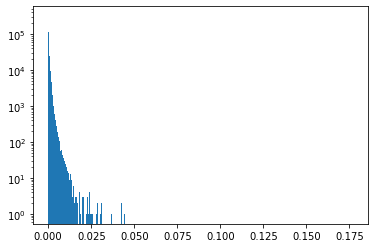

9000000


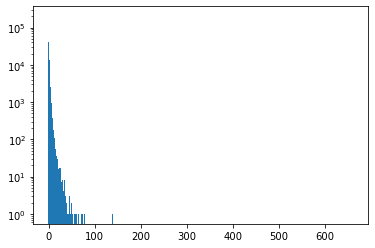

In [10]:
var=4
trackvar = X[:,:,var]
trackvar = trackvar[~(trackvar == np.NaN)]
print(len(trackvar))

plt.hist(trackvar,bins='scott',log=True)
plt.show()

trackvar2 = Xscaled[:,:,var]
trackvar2 = trackvar2[~(trackvar2 == np.NaN)]
print(len(trackvar2))


plt.hist(trackvar2,bins='scott',log=True)
plt.show()

In [11]:
Xscaled = np.nan_to_num(Xscaled)

Now we scale the outputs, actually more simple, we change units from metres to millimetres

And the secondary and tertiary vertices as our labels

In [12]:
y = bjets_DF[['secVtx_x','secVtx_y','secVtx_z','terVtx_x','terVtx_y','terVtx_z']].values 
y = y*1000 # change units of vertices from m to mm, keep vals close to unity 
# again convention call labels 'y'

Split first 80000 jets as train and next 20000 as test. Below some plots to show these jets are equivalently distributed

In [15]:
X=np.nan_to_num(X)

In [13]:
split= 280000 #int(0.9*len(bjets_DF))
X_train=Xscaled[:split]
X_test=Xscaled[split:]
y_train=y[:split]
y_test=y[split:]
print(split)

280000


In [14]:
b_s1=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[:split]
b_s2=np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:]
b_t1=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[:split]
b_t2=np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:]
plt.show()

0.003692907440001235
0.007052196938718495


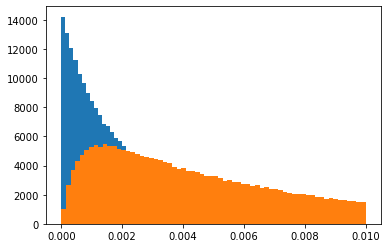

In [15]:
plt.hist(b_s1,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t1,bins='scott',range=[0,0.01])

print(np.mean(b_s1))
print(np.mean(b_t1))


0.003677823824678882
0.007054699605665886


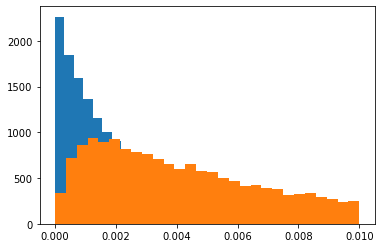

In [16]:
plt.hist(b_s2,bins='scott',range=[0,0.01])
#plt.hist(c_SecVtx,bins='scott',range=[0,0.01])
plt.hist(b_t2,bins='scott',range=[0,0.01])

print(np.mean(b_s2))
print(np.mean(b_t2))


So finally we have our features, X, and labels, y. Split into training and testing samples.

## Data Plots and Sanity Checks

Here I should have some plots on the track variables to ensure everything is logical and working fine, especially when I make changes to the data. Can potentially use seaborn...

## Constructing and Training an RNN

Here we create an RNN based on LSTM cells using keras and tensorflow. The RNN will for each jet candidate take the tracks as inputs and attempt to predict the secondary and tertiary vertex positions. Let's see how well it does.

I anticipate having to set a tolerance on the predicted values, it will never get them perfectly but we need to tell it how close it has to get for it to be considered successful.

Let's begin by creating the RNN architecture

In [17]:
# Select number of hidden and dense layers. Initially use same as RNNIP but these can be tuned going forward.

nHidden = 512
nDense = 32

In [18]:
nJets, nTrks, nFeatures = X_train.shape
nOutputs = y.shape[1] # ie sec and ter vtx xyz, so 6

In [19]:
trk_inputs = Input(shape=(nTrks,nFeatures),name="Trk_inputs")
masked_input = Masking()(trk_inputs)

# Feed this merged layer to an RNN
lstm = LSTM(nHidden, return_sequences=False, name='LSTM')(masked_input)
dpt = Dropout(rate=0.2)(lstm) # this is a very high dropout rate, reduce it

my_inputs = trk_inputs

# Fully connected layer: This will convert the output of the RNN to our vtx postion predicitons
FC = Dense(nDense, activation='relu', name="Dense")(dpt) # is relu fine here? i think so...

# Ouptut layer. Sec and Ter Vtx. No activation as this is a regression problem
output = Dense(nOutputs, name="Vertex_Predictions")(FC)

myRNN = Model(inputs=my_inputs, outputs=output)


In [20]:
myRNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Trk_inputs (InputLayer)      (None, 30, 5)             0         
_________________________________________________________________
masking_1 (Masking)          (None, 30, 5)             0         
_________________________________________________________________
LSTM (LSTM)                  (None, 512)               1060864   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
Dense (Dense)                (None, 32)                16416     
_________________________________________________________________
Vertex_Predictions (Dense)   (None, 6)                 198       
Total params: 1,077,478
Trainable params: 1,077,478
Non-trainable params: 0
_________________________________________________________________


In [21]:
myRNN.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mae']) # do i want to add a metric like mse to evaluate during training


 checkpoints, training, evaluation of performance
 different ways of evaluating performance obviously
 either akin to Nicole's method for RNNIP
 or the slighlty different method in https://github.com/agu3rra/NeuralNetwork-RegressionExample/blob/master/Tutorial.ipynb

In [22]:
myRNN_mChkPt = ModelCheckpoint('myRNN_weights.h5',monitor='val_loss', verbose=True,
                               save_best_only=True,
                               save_weights_only=True)

In [23]:
earlyStop = EarlyStopping(monitor='val_loss', verbose=True, patience=10)


In [51]:
nEpochs = 100

myRNN_hist = myRNN.fit(X_train, y_train, epochs=nEpochs, batch_size=256,validation_split=0.20,
                 callbacks=[earlyStop, myRNN_mChkPt],) # callbacks=[earlyStop, myRNN_mChkPt])

Train on 224000 samples, validate on 56000 samples
Epoch 1/100
224000/224000 [==============================] - 73s 324us/step - loss: 0.9767 - mean_absolute_error: 0.9767 - val_loss: 0.8014 - val_mean_absolute_error: 0.8014
Epoch 2/100
224000/224000 [==============================] - 77s 345us/step - loss: 0.7798 - mean_absolute_error: 0.7798 - val_loss: 0.7125 - val_mean_absolute_error: 0.7125
Epoch 3/100
224000/224000 [==============================] - 77s 343us/step - loss: 0.7018 - mean_absolute_error: 0.7018 - val_loss: 0.6337 - val_mean_absolute_error: 0.6337
Epoch 4/100
224000/224000 [==============================] - 76s 341us/step - loss: 0.6381 - mean_absolute_error: 0.6381 - val_loss: 0.5898 - val_mean_absolute_error: 0.5898
Epoch 5/100
224000/224000 [==============================] - 78s 348us/step - loss: 0.5966 - mean_absolute_error: 0.5966 - val_loss: 0.5517 - val_mean_absolute_error: 0.5517
Epoch 6/100
224000/224000 [==============================] - 76s 338us/step - l

Epoch 24/100
224000/224000 [==============================] - 73s 326us/step - loss: 0.3531 - mean_absolute_error: 0.3531 - val_loss: 0.3371 - val_mean_absolute_error: 0.3371
Epoch 25/100
224000/224000 [==============================] - 72s 322us/step - loss: 0.3450 - mean_absolute_error: 0.3450 - val_loss: 0.3126 - val_mean_absolute_error: 0.3126
Epoch 26/100
224000/224000 [==============================] - 73s 326us/step - loss: 0.3395 - mean_absolute_error: 0.3395 - val_loss: 0.3141 - val_mean_absolute_error: 0.3141
Epoch 27/100
224000/224000 [==============================] - 73s 327us/step - loss: 0.3335 - mean_absolute_error: 0.3335 - val_loss: 0.3123 - val_mean_absolute_error: 0.3123
Epoch 28/100
224000/224000 [==============================] - 73s 327us/step - loss: 0.3267 - mean_absolute_error: 0.3267 - val_loss: 0.3023 - val_mean_absolute_error: 0.3023
Epoch 29/100
224000/224000 [==============================] - 73s 328us/step - loss: 0.3206 - mean_absolute_error: 0.3206 - v

224000/224000 [==============================] - 75s 334us/step - loss: 0.2147 - mean_absolute_error: 0.2147 - val_loss: 0.2091 - val_mean_absolute_error: 0.2091
Epoch 74/100
224000/224000 [==============================] - 76s 337us/step - loss: 0.2144 - mean_absolute_error: 0.2144 - val_loss: 0.2177 - val_mean_absolute_error: 0.2177
Epoch 75/100
224000/224000 [==============================] - 75s 334us/step - loss: 0.2124 - mean_absolute_error: 0.2124 - val_loss: 0.2113 - val_mean_absolute_error: 0.2113
Epoch 00075: early stopping


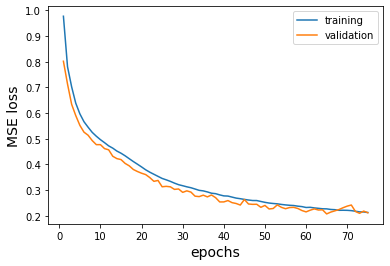

In [52]:
epochs = np.arange(1,len(myRNN_hist.history['loss'])+1)

plt.plot(epochs,myRNN_hist.history['loss'],label='training')
plt.plot(epochs,myRNN_hist.history['val_loss'],label='validation')
plt.xlabel('epochs',fontsize=14)
plt.ylabel('MSE loss',fontsize=14)
plt.legend()

# Result Analysis

Section to produce plots to understand our RNN performance. Ultimately we want to understand how our RNN gets its results, and why it gets these particular results. E.g. is our performance limited by resolution, bad results due to one particular track, how do different displacements of the sec vertex affect performance, how do n of sec or tertiary tracks, ...


First we load the best performing model from its weights file

In [28]:
# load model
myRNN.load_weights('./512over32RNNweights.h5')


Use the RNN now to predict the vertices of a test sample X_test. This is essentially 20000 jets, each jet consisting of its track collection (the first track in the collection is an artificial one consisting of the measured jet direction)

In [29]:
results=myRNN.predict(X_test)
results

array([[2.1222038 , 2.1254056 , 3.0007064 , 3.8185515 , 3.8182008 ,
        4.664886  ],
       [2.1364229 , 2.1410332 , 3.0219123 , 3.8928642 , 3.9022589 ,
        5.8403635 ],
       [0.5065276 , 0.510499  , 0.7176912 , 2.3371904 , 2.335762  ,
        3.461834  ],
       ...,
       [0.92011166, 0.91872525, 1.298028  , 1.0607064 , 1.0509801 ,
        1.5600872 ],
       [0.09606165, 0.0973157 , 0.1343332 , 0.11231345, 0.11265254,
        0.15907413],
       [2.5558248 , 2.5581825 , 3.6128669 , 4.0789776 , 4.0837207 ,
        5.5745354 ]], dtype=float32)

In [30]:
percentage_errs=(abs((results-y_test)/y_test)*100) # average error of 50%, so for vtx at 1mm, we get within 0.5mm
mean_abs_errs = abs((results-y_test))
mae_per_jet = np.mean(mean_abs_errs,axis=1)

### Errors against Sec Vtx Displacement

Look at the percentage and absolute errors of jets in two regions. Regions separated by the absolute displacement of secondary (and tertiary) vertex, ds. Find a phase behaviour transition arond ds=1mm

In [36]:
# separate out large ds jets
tervtx_cond = np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:] > 1.4/1000
secvtx_cond = np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:] > 1.4/1000
large_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("large ds mean % err",np.mean(percentage_errs[large_displaced_bs_indices]))
# so for jets where both sec and ter vtx are more than 1mm displaced, the percentage error is average 3% (and median 2%)
large_ds_perc_errs = np.mean(percentage_errs[large_displaced_bs_indices],axis=1)
large_ds_maes = mae_per_jet[large_displaced_bs_indices]


# now do same for small ds jets
tervtx_cond = np.linalg.norm(bjets_DF[['terVtx_x','terVtx_y','terVtx_z']],axis=1)[split:] < 1.5/1000
secvtx_cond = np.linalg.norm(bjets_DF[['secVtx_x','secVtx_y','secVtx_z']],axis=1)[split:] < 1.5/1000
small_displaced_bs_indices= np.where(secvtx_cond & tervtx_cond)[0]
print("small ds mean % err",np.mean(percentage_errs[small_displaced_bs_indices]))
small_ds_perc_errs = np.mean(percentage_errs[small_displaced_bs_indices],axis=1)
small_ds_maes = mae_per_jet[small_displaced_bs_indices]

large ds mean % err 3.0268734312891548
small ds mean % err 23.26733196993836


Text(0.5, 0, 'Mean Abs Error')

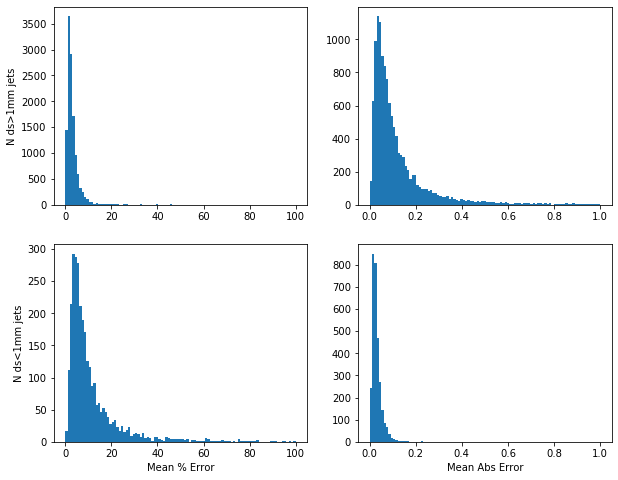

In [37]:
fig, axs = plt.subplots(2,2,figsize=(10,8))

axs[0, 0].hist(large_ds_perc_errs,np.linspace(0,100,100))
axs[0, 0].set_ylabel('N ds>1mm jets')

axs[0, 1].hist(large_ds_maes,bins=np.linspace(0,1,100))

axs[1, 0].hist(small_ds_perc_errs,np.linspace(0,100,100))
axs[1, 0].set_xlabel('Mean % Error')
axs[1, 0].set_ylabel('N ds<1mm jets')

axs[1, 1].hist(small_ds_maes,bins=np.linspace(0,1,100))
axs[1, 1].set_xlabel('Mean Abs Error')


Look at one of the outlier cases, a large ds with the largest percentage error

In [39]:
print(np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1)))
argmaxind = np.argmax(np.mean(percentage_errs[large_displaced_bs_indices],axis=1))
actual_ind = large_displaced_bs_indices[argmaxind]
np.sqrt(bjets_DF.iloc[split+actual_ind]['secVtx_x']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_y']**2 + bjets_DF.iloc[split+actual_ind]['secVtx_z']**2)
#np.linalg.norm(bjets_DF.iloc[split+1853]['secVtx_x','secVtx_y','secVtx_z'],axis=1)

5453


0.0038724467979917303

We can use actual_ind later to plot the image of this jet.

### Plot of errors for each value

Plots all the individual (secondary x, secondary y, secondary z, tertiary x...) % errors, the distribution looks gaussian with a very long tail

Text(0.5, 0, '% errors in sec and ter xyz')

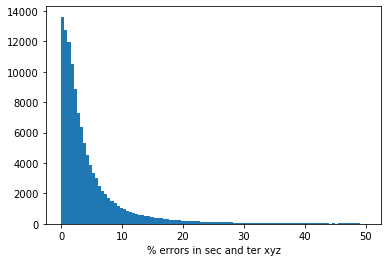

In [40]:
percerrs=percentage_errs.reshape(120000)# plot distribution of mean errs per jet

plt.hist((percerrs), bins=np.linspace(0,50,100))#90,100,200,300,400,500,600,700,800,900])
plt.xlabel('% errors in sec and ter xyz')

#plt.hist((meanerrs), bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])


In [41]:
mean_perc_err_per_jet=np.mean(percentage_errs,axis=1)

In [42]:
print(np.median(mae_per_jet)) # median error is 7% that's actually not too bad considering gauss err of 1% on 5 params (ish)
print(np.mean(mae_per_jet)) # mean and median very different

0.05813817295916562
0.10596260533642193


### Bad jet analysis

Idea here to analyse the worse performing jets. Difficulty is defining bad performance. I've done this by combining bad absolute and percentage error (see below). Unfortunately also means we are looking at the tail of performance (only about 2% jets)

In [44]:
print(len(mae_per_jet[mae_per_jet > .5])/20000, "of jets mean absolute errors above .5")

0.02465 of jets mean absolute errors above .5


In [45]:
badjets=np.where(mae_per_jet > .5)


(array([289., 110.,  33.,  25.,  14.,   5.,   6.,   5.,   1.,   0.,   1.,
          0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.50079213,  0.82052572,  1.1402593 ,  1.45999289,  1.77972648,
         2.09946007,  2.41919366,  2.73892724,  3.05866083,  3.37839442,
         3.69812801,  4.0178616 ,  4.33759518,  4.65732877,  4.97706236,
         5.29679595,  5.61652953,  5.93626312,  6.25599671,  6.5757303 ,
         6.89546389,  7.21519747,  7.53493106,  7.85466465,  8.17439824,
         8.49413183,  8.81386541,  9.133599  ,  9.45333259,  9.77306618,
        10.09279977, 10.41253335]),
 <a list of 31 Patch objects>)

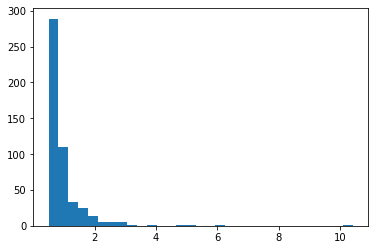

In [47]:
plt.hist(mae_per_jet[badjets],bins='scott')

In [49]:
# here's  a particular bad jet
jet=badjets[0][0]
print("this bad jet has a mean % err",mean_perc_err_per_jet[jet])
print("this bad jet has a mean abs err",mae_per_jet[jet])

this bad jet has a mean % err 7.123442650408525
this bad jet has a mean abs err 0.6836568173986107


In [50]:
y_test[jet]

array([ 6.50529031,  6.50529031,  9.19986979,  9.04314636,  8.65457936,
       12.49319372])

In [51]:
results[jet]

array([ 6.66779  ,  6.673823 ,  9.429389 ,  7.795134 ,  7.8096933,
       11.044703 ], dtype=float32)

Now we loop over our worst jets, define these as having an abs err > 0.2mm and percentage error > 10%. We then look at the parameters of these bad jets, e.g. phi, theta, momentum, n of sec tracks, n of ter tracks, phis of the sec tracks (this last is moving towards the idea of examining the individual tracks in worst performing jets)

In [54]:
indices=280000+np.where(np.logical_and(mae_per_jet > .2, mean_perc_err_per_jet> 10.))[0] # 0.2 is pretty arbitrary, 0.2 for a jet with 20mm sec vtx is actually good
print("we have "+str(len(indices))+" bad jets")
bad_phis=[]
bad_thetas=[]
bad_1OverP=[]
bad_sectrkphis=[]
bad_nSecTrks=[]
bad_nTerTrks=[]

bad_sumSecTerTrks=[]

for index in indices:
    # extracts all the phi values of worst performing jets
    bad_phis.append(abs(bjets_DF.iloc[index]['tracks'][0][2]))
    bad_thetas.append(abs(bjets_DF.iloc[index]['tracks'][0][3]))
    bad_1OverP.append(abs(bjets_DF.iloc[index]['tracks'][0][4]))
    bad_sectrkphis.append(abs(bjets_DF.iloc[index]['tracks'][1][3]))
    bad_nSecTrks.append(bjets_DF.iloc[index]['nSecTracks'])
    bad_nTerTrks.append(bjets_DF.iloc[index]['nTerTracks'])

    bad_sumSecTerTrks.append(bjets_DF.iloc[index]['nSecTracks'] + bjets_DF.iloc[index]['nTerTracks'])


we have 355 bad jets


Below I plot the phis of sec tracks in badjets and the thetas of the the bad jets, the latter is just pi/4 as we fixed to this direction in simulation. I have suppressed the output here with %%capture as its is not instructive

In [55]:
%%capture
plt.hist(bad_sectrkphis,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)
plt.show()

plt.hist(bad_thetas,bins=np.linspace(0.,3.2,65))
plt.axvline(x=np.pi/2, color='r', linestyle='dashed', linewidth=2)


More plots, first let us plot the momentum distribution of the bad jets. Higher momentum jets have more displaced vertices and thus higher absolute errors. Lower momentum jets conversely have higher percentage errors due to resolution limits.

(array([57., 32., 50., 37., 44., 65., 70.]),
 array([ 6219.03472386, 16965.84988968, 27712.66505549, 38459.48022131,
        49206.29538713, 59953.11055294, 70699.92571876, 81446.74088458]),
 <a list of 7 Patch objects>)

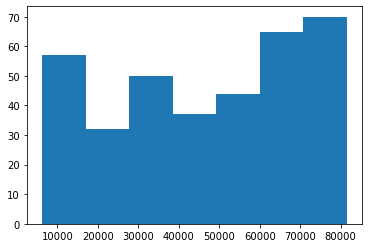

In [57]:
#plt.hist(bad_1OverP,bins=np.linspace(0.,3.2,65))
bad_ps=np.reciprocal(bad_1OverP)
plt.hist(bad_ps,bins='scott')


Next look at the (true) number of secondary and tertiary tracks in the bad jets

(array([121., 111., 123.]), array([1, 2, 3, 4]), <a list of 3 Patch objects>)

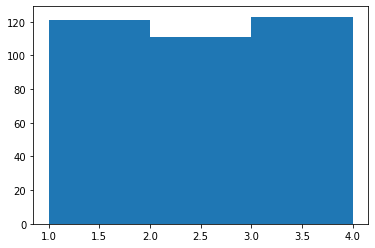

In [58]:
plt.hist(bad_nSecTrks, bins=[1,2,3,4])


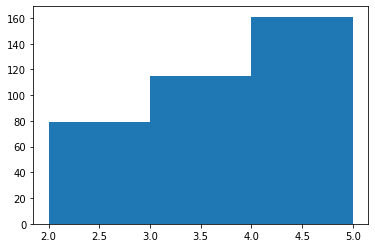

In [59]:
plt.hist(bad_nTerTrks, bins=[2,3,4,5,])
plt.show()
#plt.hist(bjets_DF['nTerTracks'], bins=[2,3,4,5])

The bad jets tend to have more tertiary tracks? Or is there not enough stats to say this.

In [ ]:
#plot the ntertracks in good jets now!!

# Jet Drawings

Here we have the code to plot the images of jets. Useful for looking at particular bad jets.

In [84]:
def get_line_from_tp(track):
    p1 = track[5:8]
    print(p1)
    phi = track[2]
    theta = track[3]
    t = np.linspace(-.005,.005,100)
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

def get_line_using_IPs(track, zoom):
    phi = track[2]
    theta = track[3]
    x0 = track[0]*np.cos(phi)
    y0 = track[0]*np.sin(phi)
    z0 = track[1]
    p1 = np.array([x0,y0,z0])
    #print(p1)

    t = np.linspace(zoom[0],zoom[1],100)
    
    xs = p1[0] + t * np.sin(theta) * np.cos(phi)
    ys = p1[1] + t * np.sin(theta) * np.sin(phi)
    zs = p1[2] + t * np.cos(theta)
    
    return xs, ys, zs

In [85]:
def from_index_extract_tracks_and_vertices(jet_index,split,trks,bjets_DF,results):
    
    full_df_index = split+jet_index
    jet_tracks = trks[full_df_index]
    prim_vertex = np.array([0,0,0])
    sec_vertex = bjets_DF[['secVtx_x','secVtx_y','secVtx_z']].iloc[full_df_index].values
    ter_vertex = bjets_DF[['terVtx_x','terVtx_y','terVtx_z']].iloc[full_df_index].values
    true_vertices =np.array([prim_vertex,sec_vertex,ter_vertex])
    rec_vertices = results[jet_index].reshape(2,3)/1000
    
    return jet_tracks, true_vertices, rec_vertices

In [86]:
def plot_jet(jet_tracks, true_vertices, rec_vertices, zoom=[-0.005,.01]):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    #plot the tracks
    for i,track in enumerate(jet_tracks):
        if i == 0: #jet direction
            xs, ys, zs = get_line_using_IPs(track, zoom)
            xs,ys,zs= 2*xs,2*ys,2*zs
            ax.plot(xs,ys,zs,'--')
        else:
            if not np.isnan(track[0]):
                xs, ys, zs = get_line_using_IPs(track, zoom)
                ax.plot(xs,ys,zs)

    #plot the true vertices
    for x, y, z in true_vertices:
        #print(x,y,z)
        ax.scatter(x, y, z, color='black', marker='s')
        
    # plot the reconstructed vertices
    for x, y, z in rec_vertices:
        #print(x,y,z)
        ax.scatter(x, y, z, color='red', marker='x')

In [134]:
good_maes=np.where(mae_per_jet < .01)
good_maes

(array([   91,   140,   180,   217,   365,   403,   437,   612,   894,
          903,   935,  1068,  1095,  1204,  1214,  1252,  1329,  1398,
         1415,  1445,  1577,  1608,  1658,  1667,  1694,  1815,  1876,
         1889,  1910,  1971,  2017,  2031,  2038,  2075,  2140,  2179,
         2306,  2371,  2484,  2504,  2538,  2539,  2556,  2595,  2634,
         2643,  2657,  2697,  2760,  2841,  2875,  2905,  2952,  2980,
         3059,  3070,  3088,  3092,  3123,  3177,  3217,  3328,  3334,
         3373,  3399,  3485,  3521,  3525,  3563,  3630,  3642,  3678,
         3733,  3754,  3927,  4026,  4032,  4061,  4131,  4132,  4151,
         4172,  4185,  4391,  4680,  4690,  4759,  4760,  4835,  4885,
         4940,  5015,  5104,  5237,  5296,  5331,  5383,  5389,  5452,
         5506,  5507,  5598,  5671,  5711,  5723,  5727,  5731,  5757,
         5776,  5809,  5831,  5881,  5892,  5920,  5922,  6028,  6068,
         6132,  6146,  6173,  6198,  6228,  6266,  6309,  6413,  6432,
      

In [112]:
bad_maes=np.where(mae_per_jet > 2.)
bad_maes

(array([  139,   162,   755,   829,  4827,  5168,  5802,  8591,  9250,
        11424, 11837, 12996, 13625, 14050, 14077, 14892, 15451, 16064,
        16876, 17034, 17684, 17800, 18206, 18549], dtype=int64),)

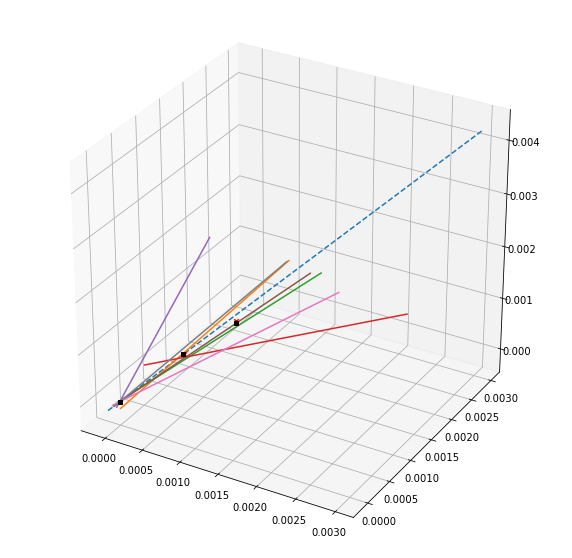

In [255]:
%matplotlib inline
goodindex = 7247
badindex = 4712

zoom = [-0.001,0.004]
#print("good")
jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(goodindex, split,trks,bjets_DF,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.0001,0.003])
#print("bad")


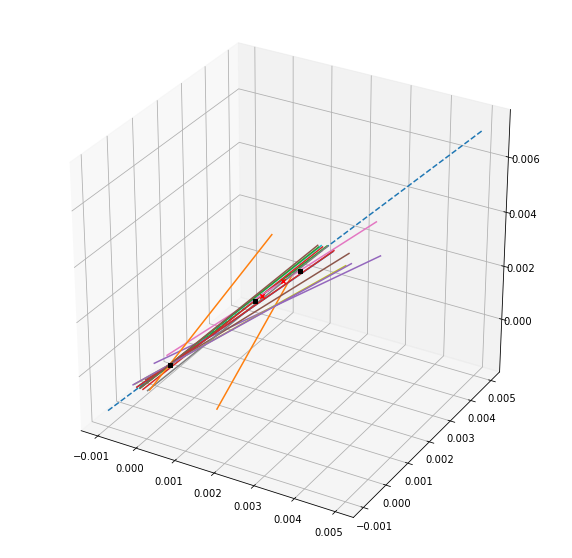

In [258]:
%matplotlib inline

jet_tracks, true_vertices, rec_vertices = from_index_extract_tracks_and_vertices(badindex, split,trks,bjets_DF,results)
plot_jet(jet_tracks, true_vertices, rec_vertices,[-0.001,0.005])

In [257]:
print(bjets_DF.iloc[goodindex+split])
print("\nand the bad\n")
print(bjets_DF.iloc[badindex+split])


jet_energy                                               51476.2
jet_flavour                                                    5
nSecTracks                                                     1
nTerTracks                                                     2
secVtx_x                                             0.000531498
secVtx_y                                             0.000531498
secVtx_z                                             0.000751652
terVtx_x                                             0.000978392
terVtx_y                                             0.000953937
terVtx_z                                              0.00122943
tracks         [[0.0, 0.0, 0.7854003036515271, 0.785399623354...
Name: 287247, dtype: object

and the bad

jet_energy                                               65354.4
jet_flavour                                                    5
nSecTracks                                                     3
nTerTracks                                      

In [116]:
mean_err_per_jet[bad_maes]

array([54.50753938,  8.71626963, 14.23357532,  9.0572393 , 12.17757914,
       28.79841386, 13.89130788, 33.20086462, 22.78810536,  8.78969183,
       11.9131622 , 14.10410563, 45.93297475,  8.82957475, 13.80848058,
       10.80994759, 14.86256421, 15.43768539, 14.68760519, 15.45878964,
       15.33526196, 14.82628395, 13.85409944, 29.69218895])

In [115]:
bad_maes

(array([  139,   162,   755,   829,  4827,  5168,  5802,  8591,  9250,
        11424, 11837, 12996, 13625, 14050, 14077, 14892, 15451, 16064,
        16876, 17034, 17684, 17800, 18206, 18549], dtype=int64),)

In [143]:
np.where(mean_err_per_jet[good_maes]>100.)


(array([ 96, 268], dtype=int64),)

In [145]:
good_maes[0][96]

5383

2

In [130]:
mean_err_per_jet[15683]

21.836243380864513

In [150]:
def my_dummy_func(blabla):
    blabla += 1
    return sec_dummy_func(blabla)
    
def sec_dummy_func(blabla2):
    if blabla2 == 1:
        boolean = False
        integer = 1
        return boolean, integer
    else:
        boolean = True
        integer = 2
        return boolean

In [151]:
my_dummy_func(0)

(False, 1)

In [152]:
my_dummy_func(2)

True